In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt



df = pd.read_csv("dirty_v3_path.csv")
cols = ["Age", "Gender", "Medical Condition", "Glucose", "Blood Pressure", "BMI", "Oxygen Saturation", "LengthOfStay", "Cholesterol",
        	"Triglycerides", "HbA1c", "Smoking", "Alcohol",	"Physical Activity", "Diet Score",	"Family History", "Stress Level",	"Sleep Hours"]

In [3]:
t = "LengthOfStay"
X = df.drop(columns=[t])
y = df[t]


In [4]:
cat_cols = ["Gender", "Medical Condition"]
num_cols = [
    "Age", "Glucose", "Blood Pressure", "BMI", "Oxygen Saturation",
    "Cholesterol", "Triglycerides", "HbA1c",
    "Smoking", "Alcohol", "Physical Activity", "Diet Score",
    "Family History", "Stress Level", "Sleep Hours"
]

preprocess = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler())
            ]),
            num_cols
        ),
        (
            "cat",
            Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("encoder", OneHotEncoder(drop="first"))
            ]),
            cat_cols
        )
    ]
)
print(X.columns.tolist())


['Age', 'Gender', 'Medical Condition', 'Glucose', 'Blood Pressure', 'BMI', 'Oxygen Saturation', 'Cholesterol', 'Triglycerides', 'HbA1c', 'Smoking', 'Alcohol', 'Physical Activity', 'Diet Score', 'Family History', 'Stress Level', 'Sleep Hours']


In [5]:
skmodel = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=69
)

skmodel.fit(X_train, y_train)



Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Glucose',
                                                   'Blood Pressure', 'BMI',
                                                   'Oxygen Saturation',
                                                   'Cholesterol',
                                                   'Triglycerides', 'HbA1c',
                                                   'Smoking', 'Alcohol',
                                                   'Physical Activity',
                                                   'Diet Score',
                                                   'Family History',
                                                   'Stress Level',
                                                   'Sleep Hours']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Gender',
                                                   'Medical Condition'])])),
                ('regressor', LinearRegression())])

In [6]:
y_pred = skmodel.predict(X_test)
print("R²:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))


R²: 0.5942869396437633
RMSE: 3.129560734586339


In [7]:
import statsmodels.api as sm

X_train_num = X_train[num_cols].apply(pd.to_numeric, errors="coerce")

train_data = X_train_num.copy()
train_data["y"] = y_train
train_data = train_data.dropna()

X_clean = sm.add_constant(train_data.drop(columns="y"))
y_clean = train_data["y"]

model = sm.OLS(y_clean, X_clean).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     252.6
Date:                Sat, 03 Jan 2026   Prob (F-statistic):               0.00
Time:                        11:26:37   Log-Likelihood:                -33963.
No. Observations:               14737   AIC:                         6.796e+04
Df Residuals:                   14721   BIC:                         6.808e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                12.5534      0.58

Variables like alcohol and smoking have higher standard errors than some of the others that we see. This could suggest that those are not as good as predictors and they might not be great predictors. The pvalue is also very much significant, even at $1$% alpha.

In [8]:
linreg = skmodel.named_steps["regressor"]
ct = skmodel.named_steps["preprocess"]

num_features = num_cols

ohe = ct.named_transformers_["cat"]
cat_features = list(ohe.get_feature_names_out(cat_cols))

all_features = num_features + cat_features
coefs = linreg.coef_

importance = pd.Series(coefs, index=all_features).sort_values(
 ascending=False
)

print(importance)

Medical Condition_Cancer          9.116877
Medical Condition_Diabetes        1.389687
Medical Condition_Hypertension    0.601765
Medical Condition_Asthma          0.484970
HbA1c                             0.185851
Glucose                           0.114948
Stress Level                      0.111646
Smoking                           0.020653
Age                               0.017646
Cholesterol                       0.017142
Family History                    0.016738
Gender_Male                       0.014802
Triglycerides                     0.014087
Alcohol                           0.003400
BMI                              -0.035297
Medical Condition_Obesity        -0.051751
Blood Pressure                   -0.059100
Oxygen Saturation                -0.062601
Diet Score                       -0.098555
Sleep Hours                      -0.105840
Physical Activity                -0.113223
Medical Condition_Healthy        -1.323384
dtype: float64


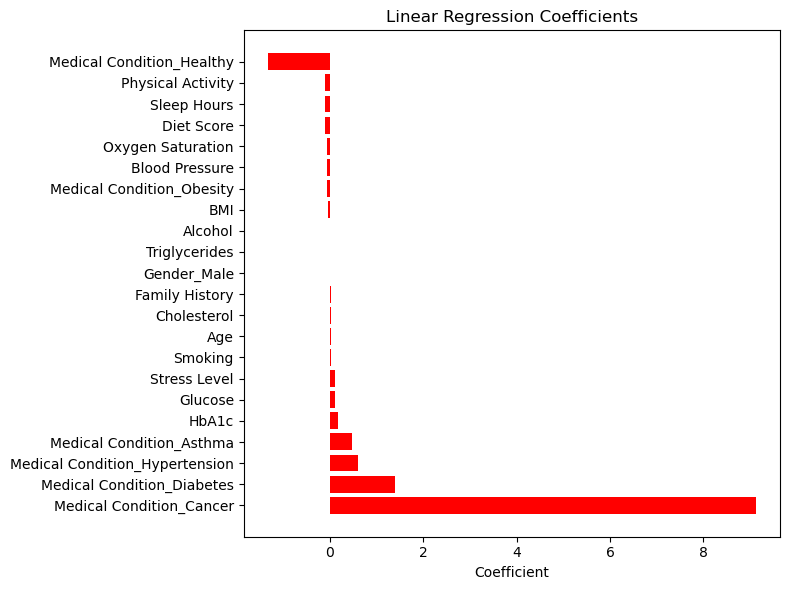

In [9]:
plt.figure(figsize=(8, 6))
plt.barh(importance.index, importance.values, color='red')
plt.xlabel("Coefficient")
plt.title("Linear Regression Coefficients")
plt.tight_layout()
plt.show()


We can see that Medical Conditions are the variables that have the highest Coefficient in termes of the time spent at the hospital, which intuitively makes sense. Besides that, the other variables have Coefficients close to zero, so they are not affecting the length of stay. Even still, the smaller numbers still intuitively make sense, as working out has a negative Coefficient, while Stress and Smoking have a positive one.

In [10]:
t = "Stress Level"
X = df.drop(columns=[t])
y = df[t]


In [11]:
cat_cols = ["Gender", "Medical Condition"]
num_cols = [
    "Age", "Glucose", "Blood Pressure", "BMI", "Oxygen Saturation",
    "Cholesterol", "Triglycerides", "HbA1c",
    "Smoking", "Alcohol", "Physical Activity", "Diet Score",
    "Family History", "LengthOfStay", "Sleep Hours"
]

preprocess = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler())
            ]),
            num_cols
        ),
        (
            "cat",
            Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("encoder", OneHotEncoder(drop="first"))
            ]),
            cat_cols
        )
    ]
)
print(X.columns.tolist())


['Age', 'Gender', 'Medical Condition', 'Glucose', 'Blood Pressure', 'BMI', 'Oxygen Saturation', 'LengthOfStay', 'Cholesterol', 'Triglycerides', 'HbA1c', 'Smoking', 'Alcohol', 'Physical Activity', 'Diet Score', 'Family History', 'Sleep Hours']


In [12]:
skmodel = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=69
)

skmodel.fit(X_train, y_train)
y_pred = skmodel.predict(X_test)
print("R²:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))



R²: 0.1991133575747316
RMSE: 3.9526520718524676


In [13]:
linreg = skmodel.named_steps["regressor"]
ct = skmodel.named_steps["preprocess"]

num_features = num_cols

ohe = ct.named_transformers_["cat"]
cat_features = list(ohe.get_feature_names_out(cat_cols))

all_features = num_features + cat_features
coefs = linreg.coef_

importance = pd.Series(coefs, index=all_features).sort_values(
 ascending=False
)

print(importance)

Medical Condition_Cancer          2.429900
Medical Condition_Hypertension    1.420924
Medical Condition_Asthma          1.326142
Medical Condition_Diabetes        1.050035
LengthOfStay                      0.170387
Blood Pressure                    0.155053
Age                               0.125333
Medical Condition_Obesity         0.114907
Cholesterol                       0.083395
Triglycerides                     0.051833
Alcohol                           0.050538
Smoking                           0.047992
Family History                    0.000817
Gender_Male                      -0.000892
BMI                              -0.001696
Oxygen Saturation                -0.011063
Glucose                          -0.015337
Physical Activity                -0.024437
Diet Score                       -0.032658
HbA1c                            -0.051489
Sleep Hours                      -0.082225
Medical Condition_Healthy        -0.248424
dtype: float64


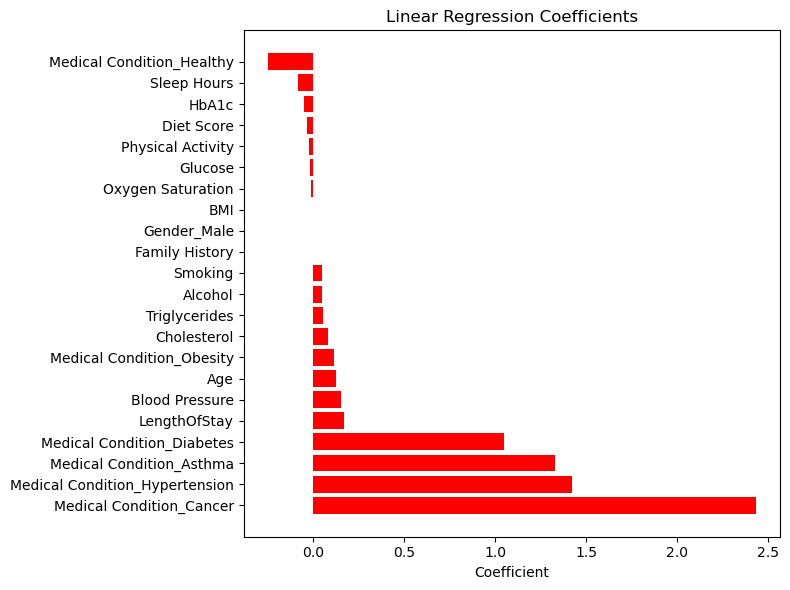

In [14]:
plt.figure(figsize=(8, 6))
plt.barh(importance.index, importance.values, color='red')
plt.xlabel("Coefficient")
plt.title("Linear Regression Coefficients")
plt.tight_layout()
plt.show()

Stress Level is a very mental variable that still has a big cause and effect with physical attributes. We can see this with Medical Conditions meaning they have the biggest Coefficients again. Interestingly, Stress increases a small amount with age. From this, we can see in order to reduce stress you want to work out and rest well, as well as have a good, low-sugar diet.